In [1]:
import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
# from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [6]:
!dir

 Volume in drive D is DATA
 Volume Serial Number is 1CA0-DCC7

 Directory of D:\WORKSPACE\HACK_PROJECT\model_files

29-02-2020  04:40 PM    <DIR>          .
29-02-2020  04:40 PM    <DIR>          ..
29-02-2020  04:10 PM    <DIR>          .ipynb_checkpoints
10-02-2020  09:21 PM         2,029,634 EDA_Complete.ipynb
29-02-2020  04:40 PM           330,902 LR Model.ipynb
               2 File(s)      2,360,536 bytes
               3 Dir(s)  262,555,119,616 bytes free


In [7]:
flights = pd.read_csv('./../eda_flights.csv')

In [4]:
flights.head()

,Unnamed: 0,DATE,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,WHEELS_OFF,DISTANCE,ELAPSED_TIMES,AIR_TIMES,TAXI_IN,SCHEDULED_ARRIVAL,WHEELS_ON,ARRIVAL_TIME,ARRIVAL_DELAY
0,0,2015-01-01 00:00:00,4,1,323,584,2015-01-01 00:05:00,23:54:00,-11.0,21.0,205.0,00:15:00,1448,254.0,229.0,4.0,04:30:00,04:04:00,04:08:00,-22.0
1,1,2015-01-01 00:00:00,4,0,482,542,2015-01-01 00:10:00,00:02:00,-8.0,12.0,280.0,00:14:00,2330,459.0,443.0,4.0,07:50:00,07:37:00,07:41:00,-9.0
2,2,2015-01-01 00:00:00,4,11,584,373,2015-01-01 00:20:00,00:18:00,-2.0,16.0,286.0,00:34:00,2296,473.0,446.0,11.0,08:06:00,08:00:00,08:11:00,5.0
3,3,2015-01-01 00:00:00,4,0,482,510,2015-01-01 00:20:00,00:15:00,-5.0,15.0,285.0,00:30:00,2342,461.0,438.0,8.0,08:05:00,07:48:00,07:56:00,-9.0
4,4,2015-01-01 00:00:00,4,1,583,324,2015-01-01 00:25:00,00:24:00,-1.0,11.0,235.0,00:35:00,1448,155.0,139.0,5.0,03:20:00,02:54:00,02:59:00,-21.0


In [8]:
flights.drop(['Unnamed: 0'], axis=1, inplace=True)
flights.head()

,DATE,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,WHEELS_OFF,DISTANCE,ELAPSED_TIMES,AIR_TIMES,TAXI_IN,SCHEDULED_ARRIVAL,WHEELS_ON,ARRIVAL_TIME,ARRIVAL_DELAY
0,2015-01-01 00:00:00,4,1,323,584,2015-01-01 00:05:00,23:54:00,-11.0,21.0,205.0,00:15:00,1448,254.0,229.0,4.0,04:30:00,04:04:00,04:08:00,-22.0
1,2015-01-01 00:00:00,4,0,482,542,2015-01-01 00:10:00,00:02:00,-8.0,12.0,280.0,00:14:00,2330,459.0,443.0,4.0,07:50:00,07:37:00,07:41:00,-9.0
2,2015-01-01 00:00:00,4,11,584,373,2015-01-01 00:20:00,00:18:00,-2.0,16.0,286.0,00:34:00,2296,473.0,446.0,11.0,08:06:00,08:00:00,08:11:00,5.0
3,2015-01-01 00:00:00,4,0,482,510,2015-01-01 00:20:00,00:15:00,-5.0,15.0,285.0,00:30:00,2342,461.0,438.0,8.0,08:05:00,07:48:00,07:56:00,-9.0
4,2015-01-01 00:00:00,4,1,583,324,2015-01-01 00:25:00,00:24:00,-1.0,11.0,235.0,00:35:00,1448,155.0,139.0,5.0,03:20:00,02:54:00,02:59:00,-21.0


# THE MODEL
___

    * Required Attributes
        * Set of Features
        * Polynomial Regression
Defining attributes chosen:
    origin airport
    destination airport
    airline
    scheduled departure
    departure delay
    distance
    scheduled arrival
    arrival delay
    day of week
    

In [9]:
def create_df(df, carrier):
    df_ = df[df['AIRLINE'] == carrier][['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY', 'DISTANCE', 'ARRIVAL_DELAY']]
    df_.dropna(how='any', inplace=True)
    
    df_['weekday'] = df_['SCHEDULED_DEPARTURE'].apply(lambda x: x.weekday())
    
    # considering only the delays less than an hour
    df_['DEPARTURE_DELAY'] = df_['DEPARTURE_DELAY'].apply(lambda x: x if x < 60 else np.nan)
    df_.dropna(how='any', inplace=True)
    
    df_['ARRIVAL_DELAY'] = df_['ARRIVAL_DELAY'].apply(lambda x: x if x < 60 else np.nan)
    df_.dropna(how='any', inplace=True)
    # formatting the times
    fct = lambda x: x.hour * 3600 + x.minute * 60 + x.second
    
    df_['t_insec_dep'] = df_['SCHEDULED_DEPARTURE'].apply(lambda x: x.time())
    df_['t_insec_dep'] = df_['t_insec_dep'].apply(fct)
    
    df_['t_insec_arr'] = df_['SCHEDULED_ARRIVAL'].apply(fct)
    
    df_mean = df_.groupby(['t_insec_dep', 't_insec_arr', 'ORIGIN_AIRPORT'], as_index=False).mean()
    
    return df_mean

In [10]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5714008 entries, 0 to 5714007
Data columns (total 19 columns):
DATE                   object
DAY_OF_WEEK            int64
AIRLINE                int64
ORIGIN_AIRPORT         int64
DESTINATION_AIRPORT    int64
SCHEDULED_DEPARTURE    object
DEPARTURE_TIME         object
DEPARTURE_DELAY        float64
TAXI_OUT               float64
SCHEDULED_TIME         float64
WHEELS_OFF             object
DISTANCE               int64
ELAPSED_TIMES          float64
AIR_TIMES              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL      object
WHEELS_ON              object
ARRIVAL_TIME           object
ARRIVAL_DELAY          float64
dtypes: float64(7), int64(5), object(7)
memory usage: 828.3+ MB


In [11]:
# CONVERT SCHEDULED_DEPARTURE to a time variable
from datetime import datetime
def conv_to_datetime(str_):
    return datetime.strptime(str_, '%Y-%m-%d %H:%M:%S')
flights['SCHEDULED_DEPARTURE'] = flights['SCHEDULED_DEPARTURE'].apply(conv_to_datetime)
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5714008 entries, 0 to 5714007
Data columns (total 19 columns):
DATE                   object
DAY_OF_WEEK            int64
AIRLINE                int64
ORIGIN_AIRPORT         int64
DESTINATION_AIRPORT    int64
SCHEDULED_DEPARTURE    datetime64[ns]
DEPARTURE_TIME         object
DEPARTURE_DELAY        float64
TAXI_OUT               float64
SCHEDULED_TIME         float64
WHEELS_OFF             object
DISTANCE               int64
ELAPSED_TIMES          float64
AIR_TIMES              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL      object
WHEELS_ON              object
ARRIVAL_TIME           object
ARRIVAL_DELAY          float64
dtypes: datetime64[ns](1), float64(7), int64(5), object(6)
memory usage: 828.3+ MB


In [12]:
def conv_to_time(str_):
    return datetime.strptime(str_, '%H:%M:%S')
flights['SCHEDULED_ARRIVAL'] = flights['SCHEDULED_ARRIVAL'].apply(conv_to_time)

flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5714008 entries, 0 to 5714007
Data columns (total 19 columns):
DATE                   object
DAY_OF_WEEK            int64
AIRLINE                int64
ORIGIN_AIRPORT         int64
DESTINATION_AIRPORT    int64
SCHEDULED_DEPARTURE    datetime64[ns]
DEPARTURE_TIME         object
DEPARTURE_DELAY        float64
TAXI_OUT               float64
SCHEDULED_TIME         float64
WHEELS_OFF             object
DISTANCE               int64
ELAPSED_TIMES          float64
AIR_TIMES              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL      datetime64[ns]
WHEELS_ON              object
ARRIVAL_TIME           object
ARRIVAL_DELAY          float64
dtypes: datetime64[ns](2), float64(7), int64(5), object(5)
memory usage: 828.3+ MB


In [9]:
# there are only 14 carriers
carrier = 0
df_mean = create_df(flights, carrier)
df_mean[:5]

,t_insec_dep,t_insec_arr,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY,weekday
0,60,31740,482,510.0,-3.000000,2342.0,0.000000,6.000000
1,300,5880,372,356.0,0.750000,546.0,1.500000,3.250000
2,300,17580,482,393.0,2.705882,1235.0,-3.176471,2.470588
3,300,17640,482,393.0,-1.594595,1235.0,-2.405405,3.027027
4,300,17700,482,393.0,5.500000,1235.0,11.500000,3.750000


In [9]:
carrier = 0
df_ = flights[flights['AIRLINE'] == carrier][['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY', 'DISTANCE', 'ARRIVAL_DELAY']]
df_.head()

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY
1,2015-01-01 00:10:00,1900-01-01 07:50:00,482,542,-8.0,2330,-9.0
3,2015-01-01 00:20:00,1900-01-01 08:05:00,482,510,-5.0,2342,-9.0
8,2015-01-01 00:30:00,1900-01-01 05:45:00,584,393,-11.0,1464,-13.0
11,2015-01-01 00:35:00,1900-01-01 08:03:00,480,510,-8.0,2174,-10.0
21,2015-01-01 01:00:00,1900-01-01 09:38:00,583,510,-8.0,2724,1.0


In [12]:
carriers = [ x for x in range(15)]
for carrier in carriers:
    df_mean = create_df(flights, carrier)
    df_mean.to_csv('model_ds/carrier' + str(carrier) + 'data.csv')

In [13]:
flights['ARRIVAL_DELAY'].head()

0   -22.0
1    -9.0
2     5.0
3    -9.0
4   -21.0
Name: ARRIVAL_DELAY, dtype: float64

In [12]:
carrier = 11
df_mean = create_df(flights, carrier)
df_mean[:5]

,t_insec_dep,t_insec_arr,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY,weekday
0,300,29280,584,373.0,2.259259,2296.0,-3.111111,3.037037
1,600,4980,372,472.0,-4.000000,328.0,-13.000000,4.000000
2,600,6600,372,570.0,8.000000,573.0,5.000000,4.000000
3,600,22440,592,545.0,7.333333,1927.0,-5.666667,3.000000
4,660,30300,482,545.0,-0.818182,2402.0,-6.000000,2.969697


In [13]:
df_mean.to_csv('model_ds/lr_model_ds.csv')

In [15]:
carrier = 11
df_mean = pd.read_csv('./../model_ds/carrier' + str(carrier) + 'data.csv')
df_mean.head()

,Unnamed: 0,t_insec_dep,t_insec_arr,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY,weekday
0,0,300,29280,584,373.0,2.259259,2296.0,-3.111111,3.037037
1,1,600,4980,372,472.0,-4.000000,328.0,-13.000000,4.000000
2,2,600,6600,372,570.0,8.000000,573.0,5.000000,4.000000
3,3,600,22440,592,545.0,7.333333,1927.0,-5.666667,3.000000
4,4,660,30300,482,545.0,-0.818182,2402.0,-6.000000,2.969697


In [37]:
# encode here and then decode later
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df_mean['ORIGIN_AIRPORT'])

zipped = zip(integer_encoded, df_mean['ORIGIN_AIRPORT'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x: x[0])

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = df_mean['ORIGIN_AIRPORT'].values.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#_________________________________________________
b = np.array(df_mean[['t_insec_dep', 't_insec_arr', 'DISTANCE', 'ARRIVAL_DELAY', 'weekday']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df_mean['DEPARTURE_DELAY'])
Y = Y.reshape(len(Y), 1)
zipped

In [38]:
# choosing the model parameters
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [39]:
import pickle

In [40]:

from sklearn.linear_model import Ridge
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(2, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        
        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))

n=1 alpha=0.2 , MSE = 24.679
n=1 alpha=0.4 , MSE = 25.48
n=1 alpha=0.6 , MSE = 26.459
n=1 alpha=0.8 , MSE = 27.449
n=1 alpha=1.0 , MSE = 28.389
n=1 alpha=1.2 , MSE = 29.263
n=1 alpha=1.4 , MSE = 30.066
n=1 alpha=1.6 , MSE = 30.801
n=1 alpha=1.8 , MSE = 31.474
n=2 alpha=0.2 , MSE = 22.885
n=2 alpha=0.4 , MSE = 23.036
n=2 alpha=0.6 , MSE = 23.188
n=2 alpha=0.8 , MSE = 23.351
n=2 alpha=1.0 , MSE = 23.526
n=2 alpha=1.2 , MSE = 23.711
n=2 alpha=1.4 , MSE = 23.905
n=2 alpha=1.6 , MSE = 24.106
n=2 alpha=1.8 , MSE = 24.311


In [96]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
filename = 'model' + str(carrier) + '.sav'
pickle.dump(ridgereg, open(filename, 'wb'))
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)
print(parameters)
print(result[0])

46.65563742408645
[2, 2]
[-2.00719447]


In [43]:
# loading the model again
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_)
score = metrics.mean_squared_error(result, Y)
print(score)

22.909487479197008


In [34]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]
df_mean['ORIGIN_AIRPORT'].replace(label_conversion, inplace=True)

for index, label in label_airports:
    temp = df_mean['ORIGIN_AIRPORT'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(df_mean[['t_insec_dep', 't_insec_arr', 'DISTANCE', 'DEPARTURE_DELAY', 'weekday']])
X_test = np.hstack((matrix, b))
Y_test = np.array(df_mean['ARRIVAL_DELAY'])
Y_test = Y_test.reshape(len(Y_test), 1)  
Y_test.shape

(7201, 1)

In [44]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print('MSE = {}'.format(round(score, 2)))

MSE = 23.13


In [45]:
'Average Delay = {:.2f} min'.format(np.sqrt(score))

'Error = 4.81 min'

In [46]:
icount = 0

for index, val in enumerate(Y_test):
    if abs(val-result[index]) > 15: icount += 1

print("error > 15 minutes: {}%".format(round((icount / len(result))*100,3)))

error > 15 minutes: 1.527%


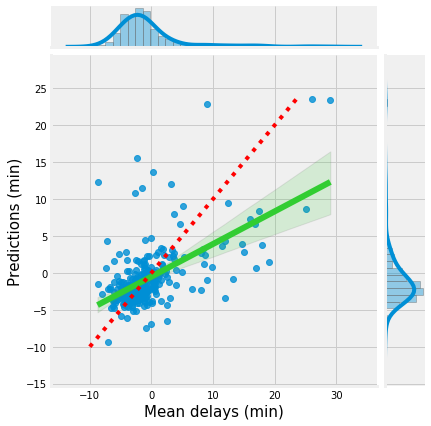

In [69]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.show()

In [70]:
# making a polynomial to fit the given data
# we saw the least error at alpha = 0.4 and polynomial order n=2

# let's make a model using these parameters
ridgereg = Ridge(alpha = 0.2, normalize=True)
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)

X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
score

21.424302836108122

In [17]:
print('MSE = {}'.format(round(score, 2)))

MSE = 50.14


In [18]:
'Average Delay = {:.2f} min'.format(np.sqrt(score))

'Error = 7.08 min'

In [19]:
icount = 0

for index, val in enumerate(Y_test):
    if abs(val-result[index]) > 15: icount += 1

print("error > 15 minutes: {}%".format(round((icount / len(result))*100,3)))

error > 15 minutes: 4.458%


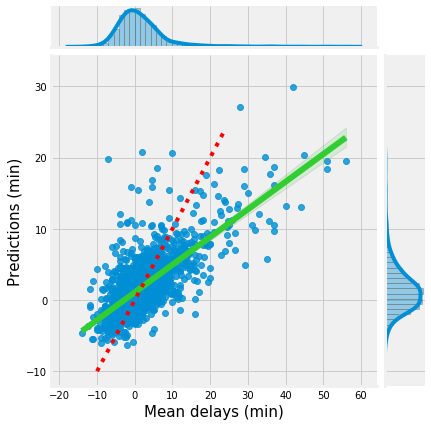

In [48]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.show()

In [29]:
# let's do the same for a smaller dataset
carrier = 0
# df_mean = create_df(flights, carrier)
df_mean = pd.read_csv('model_ds/carrier' + str(carrier) + 'data.csv')
df_mean[:5]
len(df_mean)

24211

In [54]:
df_m = df_mean[:1000]

In [72]:

# trying out different methods
# encode here and then decode later
label_encoder = LabelEncoder()


onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = df_m['ORIGIN_AIRPORT'].values.reshape(len(df_m['ORIGIN_AIRPORT']), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#_________________________________________________
b = np.array(df_m[['t_insec_dep', 't_insec_arr', 'DISTANCE', 'DEPARTURE_DELAY', 'weekday']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df_m['ARRIVAL_DELAY'])
Y = Y.reshape(len(Y), 1)
zipped

In [73]:
# choosing the model parameters
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [91]:
ridgereg = Ridge(alpha = 0.4, normalize=True)
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)

X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print('MSE = {}'.format(round(score, 2)))
print('Average Delay = {:.2f} min'.format(np.sqrt(score)))
icount = 0

for index, val in enumerate(Y_test):
#     print(val, " val and res ", result[index])
    if abs(val-result[index]) > 15: icount += 1

print("error > 15 minutes: {}%".format(round((icount / len(result))*100,3)))

# print(X_.shape, " ", Y_test.shape, " ", result.shape)
# print(X_test[0])



MSE = 62.61
Average Delay = 7.91 min
error > 15 minutes: 5.0%


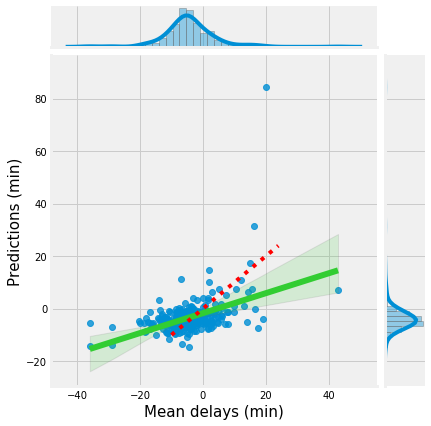

In [75]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.show()

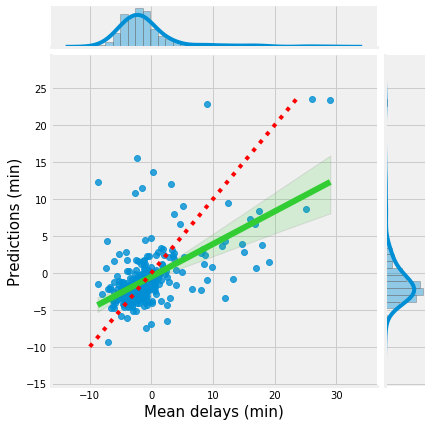

In [68]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.show()

In [70]:
# the figure styling class
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])

# MAKING THE GENERAL MODEL
___


In [19]:
!dir

 Volume in drive D is DATA
 Volume Serial Number is 1CA0-DCC7

 Directory of D:\WORKSPACE\HACK_PROJECT

11-02-2020  02:35 AM    <DIR>          .
11-02-2020  02:35 AM    <DIR>          ..
11-02-2020  01:52 AM    <DIR>          .ipynb_checkpoints
06-02-2020  11:54 PM    <DIR>          datasets
10-02-2020  09:21 PM         2,029,634 EDA_Complete.ipynb
09-02-2020  12:31 AM       835,257,393 eda_flights.csv
05-01-2020  03:51 PM           814,752 Exploratory Data Analysis for Flights Arrival and Departure Dataset.ipynb
05-01-2020  03:34 PM           113,844 Exploratory Data Analysis Of Airlines Dataset.ipynb
07-02-2020  01:52 AM       917,166,702 flights_changed_times.csv
11-02-2020  02:10 AM            28,307 General LR Model.ipynb
06-02-2020  09:20 PM        82,536,473 How to make a map in python using basemap.mp4
04-01-2020  08:35 PM            35,823 LICENSE
11-02-2020  02:35 AM           234,581 LR Model.ipynb
11-02-2020  12:23 AM           413,710 Model.ipynb
10-02-2020  11:34 PM    <D

In [20]:
flights = pd.read_csv('eda_flights.csv')

In [21]:
flights.drop(['Unnamed: 0'], axis=1, inplace=True)
flights.head()

,DATE,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,WHEELS_OFF,DISTANCE,ELAPSED_TIMES,AIR_TIMES,TAXI_IN,SCHEDULED_ARRIVAL,WHEELS_ON,ARRIVAL_TIME,ARRIVAL_DELAY
0,2015-01-01 00:00:00,4,1,323,584,2015-01-01 00:05:00,23:54:00,-11.0,21.0,205.0,00:15:00,1448,254.0,229.0,4.0,04:30:00,04:04:00,04:08:00,-22.0
1,2015-01-01 00:00:00,4,0,482,542,2015-01-01 00:10:00,00:02:00,-8.0,12.0,280.0,00:14:00,2330,459.0,443.0,4.0,07:50:00,07:37:00,07:41:00,-9.0
2,2015-01-01 00:00:00,4,11,584,373,2015-01-01 00:20:00,00:18:00,-2.0,16.0,286.0,00:34:00,2296,473.0,446.0,11.0,08:06:00,08:00:00,08:11:00,5.0
3,2015-01-01 00:00:00,4,0,482,510,2015-01-01 00:20:00,00:15:00,-5.0,15.0,285.0,00:30:00,2342,461.0,438.0,8.0,08:05:00,07:48:00,07:56:00,-9.0
4,2015-01-01 00:00:00,4,1,583,324,2015-01-01 00:25:00,00:24:00,-1.0,11.0,235.0,00:35:00,1448,155.0,139.0,5.0,03:20:00,02:54:00,02:59:00,-21.0


In [10]:
# create data frames for each of the dataset and load them whenever required
print(set(flights['AIRLINE'].tolist()))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}


In [3]:
# the user inputs are:
"""
CARRIER
DEPARTURE TIME
SCHEDULED ARRIVAL
DISTANCE
WEEKDAY
ORIGIN AIRPORT
DESTINATION AIRPORT

"""

# to be predicted is the arrival delay

'\nCARRIER\nDEPARTURE TIME\nSCHEDULED ARRIVAL\nDISTANCE\nWEEKDAY\nORIGIN AIRPORT\nDESTINATION AIRPORT\n\n'

In [4]:
carriers = [x for x in range(14)]
import pickle

list_airports = pd.read_csv('datasets/airports.csv')
list_airports.head()
ap_dict = list_airports.set_index('IATA_CODE')['AIRPORT'].to_dict()
list_air = list(ap_dict)
list_air
dict_ap = []
index = 0
for item in list_air:
    dict_ap.append([index, item])
    index += 1

In [34]:
from sklearn.linear_model import Ridge
for carrier in carriers:
    # open the df
    df_mean = pd.read_csv('model_ds/carrier' + str(carrier) + 'data.csv')
    
    # do the encoding of the data
    # encode here and then decode later
n

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded_origin = onehot_encoder.fit_transform(integer_encoded)

    #_________________________________________________
    b = np.array(df_mean[['t_insec_dep', 't_insec_arr', 'DISTANCE', 'DEPARTURE_DELAY', 'weekday']])
    X = np.hstack((onehot_encoded_origin, b))

    Y = np.array(df_mean['ARRIVAL_DELAY'])
    Y = Y.reshape(len(Y), 1)
    
    # choosing the model parameters
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
    # define and save the model
    
    ridgereg = Ridge(alpha = 0.2, normalize=True)
    poly = PolynomialFeatures(degree = 1)
    X_ = poly.fit_transform(X)
    ridgereg.fit(X_, Y)
    filename = 'models/model' + str(carrier) + '.sav'
    pickle.dump(ridgereg, open(filename, 'wb'))
    result = ridgereg.predict(X_)
    score = metrics.mean_squared_error(result, Y)        
    print('MSE = {}'.format(round(score, 2)))
    print('Error = {:.2f} min'.format(np.sqrt(score)))
    icount = 0

    for index, val in enumerate(Y_test):
        if abs(val-result[index]) > 15: icount += 1

    print("error > 15 minutes: {}%".format(round((icount / len(result))*100,3)))

print(X_)
    

MSE = 53.21
Error = 7.29 min
error > 15 minutes: 4.073%
MSE = 48.09
Error = 6.93 min
error > 15 minutes: 3.488%
MSE = 58.82
Error = 7.67 min
error > 15 minutes: 5.488%
MSE = 68.09
Error = 8.25 min
error > 15 minutes: 4.824%
MSE = 70.95
Error = 8.42 min
error > 15 minutes: 6.207%
MSE = 59.74
Error = 7.73 min
error > 15 minutes: 6.454%
MSE = 19.85
Error = 4.46 min
error > 15 minutes: 1.049%
MSE = 53.63
Error = 7.32 min
error > 15 minutes: 5.472%
MSE = 42.66
Error = 6.53 min
error > 15 minutes: 4.274%
MSE = 69.2
Error = 8.32 min
error > 15 minutes: 6.266%
MSE = 99.81
Error = 9.99 min
error > 15 minutes: 8.49%
MSE = 51.96
Error = 7.21 min
error > 15 minutes: 4.194%
MSE = 57.17
Error = 7.56 min
error > 15 minutes: 6.225%
MSE = 41.4
Error = 6.43 min
error > 15 minutes: 5.674%


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [12]:
# create the input pipeline
df = pd.read_csv('datasets/flights.csv')
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
print(X_.shape)

(59001, 178)


In [13]:
df_carrier0 = df[df['AIRLINE'] == 'AS']

In [14]:
df_carrier0.tail()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
5819052,2015,12,31,4,AS,111,N586AS,LAS,ANC,2355,2340.0,-15.0,20.0,2400.0,360.0,313.0,289.0,2304,349.0,4.0,455,353.0,-62.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819053,2015,12,31,4,AS,121,N768AS,SEA,ANC,2355,2355.0,0.0,11.0,6.0,236.0,209.0,194.0,1448,220.0,4.0,251,224.0,-27.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819054,2015,12,31,4,AS,175,N431AS,LAX,ANC,2355,2350.0,-5.0,16.0,6.0,350.0,310.0,291.0,2345,357.0,3.0,445,400.0,-45.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819055,2015,12,31,4,AS,471,N570AS,LAX,SEA,2355,2353.0,-2.0,17.0,10.0,169.0,152.0,132.0,954,222.0,3.0,244,225.0,-19.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819056,2015,12,31,4,AS,850,N536AS,KOA,SEA,2355,2352.0,-3.0,16.0,8.0,355.0,320.0,298.0,2688,706.0,6.0,750,712.0,-38.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
print(type(df_carrier0['SCHEDULED_DEPARTURE'][0]))

<class 'numpy.int64'>


In [23]:
airlines_names = pd.read_csv('datasets/airlines.csv')
airlines_names
abbreviations_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()
index = 0
dict_aa = []
list_aa = list(abbreviations_companies)
for item in list_aa:
    dict_aa.append([index, item])
    index += 1
dict_aa

[[0, 'UA'],
 [1, 'AA'],
 [2, 'US'],
 [3, 'F9'],
 [4, 'B6'],
 [5, 'OO'],
 [6, 'AS'],
 [7, 'NK'],
 [8, 'WN'],
 [9, 'DL'],
 [10, 'EV'],
 [11, 'HA'],
 [12, 'MQ'],
 [13, 'VX']]

In [24]:
list_aa = list(map(list, abbreviations_companies.items()))
list_aa

[['UA', 'United Air Lines Inc.'],
 ['AA', 'American Airlines Inc.'],
 ['US', 'US Airways Inc.'],
 ['F9', 'Frontier Airlines Inc.'],
 ['B6', 'JetBlue Airways'],
 ['OO', 'Skywest Airlines Inc.'],
 ['AS', 'Alaska Airlines Inc.'],
 ['NK', 'Spirit Air Lines'],
 ['WN', 'Southwest Airlines Co.'],
 ['DL', 'Delta Air Lines Inc.'],
 ['EV', 'Atlantic Southeast Airlines'],
 ['HA', 'Hawaiian Airlines Inc.'],
 ['MQ', 'American Eagle Airlines Inc.'],
 ['VX', 'Virgin America']]

In [25]:
list_airports = pd.read_csv('datasets/airports.csv')
list_airports.head()
ap_dict = list_airports.set_index('IATA_CODE')['AIRPORT'].to_dict()
list_air = list(ap_dict)
list_air
dict_ap = []
index = 0
for item in list_air:
    dict_ap.append([index, item])
    index += 1
dict_ap

[[0, 'ABE'],
 [1, 'ABI'],
 [2, 'ABQ'],
 [3, 'ABR'],
 [4, 'ABY'],
 [5, 'ACK'],
 [6, 'ACT'],
 [7, 'ACV'],
 [8, 'ACY'],
 [9, 'ADK'],
 [10, 'ADQ'],
 [11, 'AEX'],
 [12, 'AGS'],
 [13, 'AKN'],
 [14, 'ALB'],
 [15, 'ALO'],
 [16, 'AMA'],
 [17, 'ANC'],
 [18, 'APN'],
 [19, 'ASE'],
 [20, 'ATL'],
 [21, 'ATW'],
 [22, 'AUS'],
 [23, 'AVL'],
 [24, 'AVP'],
 [25, 'AZO'],
 [26, 'BDL'],
 [27, 'BET'],
 [28, 'BFL'],
 [29, 'BGM'],
 [30, 'BGR'],
 [31, 'BHM'],
 [32, 'BIL'],
 [33, 'BIS'],
 [34, 'BJI'],
 [35, 'BLI'],
 [36, 'BMI'],
 [37, 'BNA'],
 [38, 'BOI'],
 [39, 'BOS'],
 [40, 'BPT'],
 [41, 'BQK'],
 [42, 'BQN'],
 [43, 'BRD'],
 [44, 'BRO'],
 [45, 'BRW'],
 [46, 'BTM'],
 [47, 'BTR'],
 [48, 'BTV'],
 [49, 'BUF'],
 [50, 'BUR'],
 [51, 'BWI'],
 [52, 'BZN'],
 [53, 'CAE'],
 [54, 'CAK'],
 [55, 'CDC'],
 [56, 'CDV'],
 [57, 'CEC'],
 [58, 'CHA'],
 [59, 'CHO'],
 [60, 'CHS'],
 [61, 'CID'],
 [62, 'CIU'],
 [63, 'CLD'],
 [64, 'CLE'],
 [65, 'CLL'],
 [66, 'CLT'],
 [67, 'CMH'],
 [68, 'CMI'],
 [69, 'CMX'],
 [70, 'CNY'],
 [71, 'COD'],
 [

In [20]:
dayOfWeek = 4
airline = 'AS'
origin = 'KOA'
dest = 'SEA'
sd = 2355
ddelay = -3
sa = 750
carrier = 0
dist = 2688

# arrival = ?

In [21]:
input_ = {
          "dayOfWeek": dayOfWeek,
          "airline": airline, 
          "origin": origin,
          "dest" : dest,
          "sd": sd, 
          "ddelay": ddelay,
          "sa": sa,
          "dist": dist

         }

print(type(np.int64(input_["sd"])))

time_ = string_to_time(input_["sd"])

<class 'numpy.int64'>
23 55


In [41]:

import datetime

def string_to_time(time_string):
    if pd.isnull(time_string):
        return np.nan
    else:
        if time_string == 2400:
            time_string  = 0
        time_string = "{0:04d}".format(int(time_string))
#         print(time_string)
#         print(type(time_string))
        print(int(time_string[0:2]), int(time_string[2:4]))
        time_ = datetime.time(int(str(time_string)[0:2]), int(str(time_string)[2:4]))
        return time_
    
def conv_to_time(str_):
    return datetime.datetime.strptime(str_, '%H:%M:%S')

def func(x):
    return x.hour * 3600 + x.minute * 60 + x.second

def processInput(input_):
    processed = []
    time_sd = string_to_time(np.int64(input_["sd"]))
    time_sa = string_to_time(np.int64(input_["sa"]))
    time_sd = func(time_sd)
    time_sa = func(time_sa)
    # encode airlines to their numbers
    airline = input_["airline"]
    origin = input_["origin"]
    dest = input_["dest"]
    for air in dict_aa:
        if airline == air[1]:
            index_airline = air[0]
            break
    for port in dict_ap:
        if origin == port[1]:
            index_origin = port[0]
            break
    for port in dict_ap:
        if dest == port[1]:
            index_dest = port[0]
            break
    label_encoder = LabelEncoder()
#     integer_encoded = label_encoder.fit_transform(index_origin)
    
#     zipped = zip(integer_encoded, index_origin)
#     label_airports = list(set(list(zipped)))
#     label_airports.sort(key = lambda x: x[0])

#     onehot_encoder = OneHotEncoder(sparse=False)
#     integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
#     onehot_encoded_origin = onehot_encoder.fit_transform(integer_encoded)
    
    
    #_________________________________________________
    b = np.array([time_sd, time_sa, ddelay, input_["dist"], input_["dayOfWeek"]])
    X = np.hstack((index_origin, b))


    return X
    

processed_data = processInput(input_)


23 55
7 50


In [43]:
processed_data.shape

(6,)

In [28]:
df_test = pd.read_csv('model_ds/carrier0data.csv')

In [29]:
df_test.head()

,Unnamed: 0,t_insec_dep,t_insec_arr,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY,weekday
0,0,60,31740,482,510.0,-3.000000,2342.0,0.000000,6.000000
1,1,300,5880,372,356.0,0.750000,546.0,1.500000,3.250000
2,2,300,17580,482,393.0,2.705882,1235.0,-3.176471,2.470588
3,3,300,17640,482,393.0,-1.594595,1235.0,-2.405405,3.027027
4,4,300,17700,482,393.0,5.500000,1235.0,11.500000,3.750000


In [44]:

poly = PolynomialFeatures(degree = 1)
processed_data = np.array(processed_data)
processed_data = processed_data.reshape(-1, 1)
print(processed_data)
processed_ = poly.fit_transform(processed_data)
test_result = ridgereg.predict(processed_)

[[  170]
 [86100]
 [28200]
 [   -3]
 [ 2688]
 [    4]]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 178 is different from 2)